In [1]:
%matplotlib  inline
import pandas as pd
import numpy as np
from snap import *


def  getGraph(nodes,edges):
    G = TUNGraph.New()
    ## 添加节点
    for node in nodes:
        G.AddNode(node) 
    ## 添加边
    for A,B in edges:
        G.AddEdge(A,B)
    return G


### 入度出度计算
def getInOutDegrees(UGraph=None):
    nodes_stats=[]
    for NI in UGraph.Nodes():
        temp=[NI.GetId(), NI.GetOutDeg(), NI.GetInDeg()]
        nodes_stats.append(temp)
    call_net_nodes=pd.DataFrame(data=nodes_stats,columns=['id','OutDeg','InDeg']).set_index('id')
    return call_net_nodes


##Uses the Clauset-Newman-Moore community detection method for large networks. 
# At every step of the algorithm two communities that contribute maximum positive value 
# to global modularity are merged. Fills CmtyV with all the communities detected and 
# returns the modularity of the network.
def getCNMCommDetect(UGraph=None):
    CmtyV = TCnComV()
    modularity = CommunityCNM(UGraph, CmtyV)
    comm=pd.DataFrame([list(line) for line in list(CmtyV)])
    return comm,modularity

## Uses the Girvan-Newman community detection algorithm based on betweenness centrality on Graph.
def getGNCommDetect(UGraph=None):
    CmtyV = TCnComV()
    modularity = snap.CommunityGirvanNewman(UGraph, CmtyV)
    comm=pd.DataFrame([list(line) for line in list(CmtyV)])
    return comm,modularity

## 得到由图中节点组成的子图
def getSubGraph(Graph,nodes):
    NIdV = snap.TIntV()
    for i in nodes:
        NIdV.Add(i)
    SubGraph = snap.GetSubGraph(Graph, NIdV)
    return SubGraph

def GetStats():
    diam = GetBfsFullDiam(Graph, 100, False)  ## 网络直径
    GraphClustCoeff= GetClustCf (Graph, -1)     ## 聚集系数
    NumTriads=GetTriads(Graph, 50)   ## 三元闭包的个数

# GetEdgesInOut(Graph, Nodes)  ## 社区内部边，社区外部的边，Graph可以是有向图或者无向图。Nodes是图中的节点Id
# snap.GetModularity(Graph, Nodes, 1000)  ## 又Nodes组成的社区的模块度，Gedges是可选参数，如果Gedes和实际不一样则得到的错误的模块度
# # convert undirected graph to directed
# GOut = snap.ConvertGraph(snap.PNGraph, GIn)  ## 实现无向图向有向图的转换，图类别的转换

def apply_packed_function_for_map((dumped_function, item, args, kwargs),):
    """
    Unpack dumped function as target function and call it with arguments.

    :param (dumped_function, item, args, kwargs):
        a tuple of dumped function and its arguments
    :return:
        result of target function
    """
    target_function = dill.loads(dumped_function)
    res = target_function(item, *args, **kwargs)
    return res


def pack_function_for_map(target_function, items, *args, **kwargs):
    """
    Pack function and arguments to object that can be sent from one
    multiprocessing.Process to another. The main problem is:
        «multiprocessing.Pool.map*» or «apply*»
        cannot use class methods or closures.
    It solves this problem with «dill».
    It works with target function as argument, dumps it («with dill»)
    and returns dumped function with arguments of target function.
    For more performance we dump only target function itself
    and don't dump its arguments.
    How to use (pseudo-code):

        ~>>> import multiprocessing
        ~>>> images = [...]
        ~>>> pool = multiprocessing.Pool(100500)
        ~>>> features = pool.map(
        ~...     *pack_function_for_map(
        ~...         super(Extractor, self).extract_features,
        ~...         images,
        ~...         type='png'
        ~...         **options,
        ~...     )
        ~... )
        ~>>>

    :param target_function:
        function, that you want to execute like  target_function(item, *args, **kwargs).
    :param items:
        list of items for map
    :param args:
        positional arguments for target_function(item, *args, **kwargs)
    :param kwargs:
        named arguments for target_function(item, *args, **kwargs)
    :return: tuple(function_wrapper, dumped_items)
        It returs a tuple with
            * function wrapper, that unpack and call target function;
            * list of packed target function and its' arguments.
    """
    dumped_function = dill.dumps(target_function)
    dumped_items = [(dumped_function, item, args, kwargs) for item in items]
    return apply_packed_function_for_map, dumped_items

def getNodeEdge(filename):
    df=pd.read_csv(filename,index_col=0)
    df.drop_duplicates(['cust_a','cust_b'],inplace=True)
    cond=(df.cust_a!=df.cust_b)
    df=df[cond]
    nodes=np.union1d(df.cust_a.unique(),df.cust_b.unique())
    edges=df.values
    return nodes,edges

def getGraph(filename,U=True):
    nodes,edges=getNodeEdge(filename)
    if U:
        G=TUNGraph.New()
    else:
        G=TNGraph.New()
    for node in nodes:
        G.AddNode(node) 
    ## 添加边
    for A,B in edges:
        G.AddEdge(A,B)
    return G

In [2]:
# app_conatcts=getGraph('chapter1data/app_contacts.csv',U=False)
# sms=getGraph('chapter1data/sms_net.csv',U=False)
call_record=getGraph('chapter1data/call_record_net.csv',U=False)
# sms_MxWcc=GetMxWcc_PNGraph(sms)    
# app_conatcts_MxWcc=GetMxWcc_PNGraph(app_conatcts)
call_record=GetMxWcc_PNGraph(call_record)

In [627]:
%%time
import dill
from snap  import *
import multiprocessing
filename='chapter1data/call_record_MxWcc.out'
sample_num=10*10000
# pids=600
# save_fileanme='chapter1data/call_record_MxWcc.csv'
# call_record=LoadPajek_PUNGraph(filename)
CDRs=[NI.GetId() for NI in call_record.Nodes()]
print 'number of Nodes:',len(CDRs)
nodes=np.array(CDRs)[np.random.randint(1,len(CDRs),sample_num)]
pool = multiprocessing.Pool(600)
features = pool.map(
     *pack_function_for_map(
        lambda  NI:[call_record.GetNI(NI).GetDeg(),GetNodeEcc(call_record,NI ),GetNodeClustCf(call_record,NI ),GetNodeTriads(call_record,NI )],
         nodes,
       
    )
)
## 最大最短路径
## 节点的聚类系数
## 节点三元闭包数量
## 节点的平均路劲长度
pd.DataFrame(features,columns=['Deg','NodeEcc','ClustCf','NodeTriads','FarnessCentr'],index=nodes).to_csv(save_fileanme)

number of Nodes: 3870431


AssertionError: 5 columns passed, passed data had 4 columns

In [630]:
pd.DataFrame(features,columns=['Deg','NodeEcc','ClustCf','NodeTriads'],index=nodes).to_csv('chapter1data/CDRs_mx_stats.csv')

In [4]:
CDRs=pd.read_csv('chapter1data/CDRs_mx_stats.csv',index_col=0)

In [5]:
import seaborn as sns
def GetPlotClust(df):
    df_cut=pd.cut(df.ClustCf,bins=10,labels=np.arange(0,1,0.1))
    df_cut_cnt=df_cut.value_counts()
    df_stats=(df_cut_cnt/df_cut_cnt.sum()).sort_index()
    return df_stats

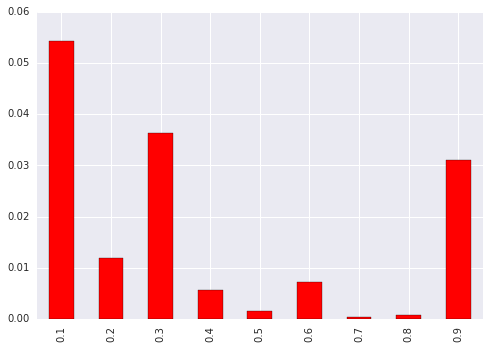

In [12]:
GetPlotClust(CDRs)[1:].plot.bar(color='red')

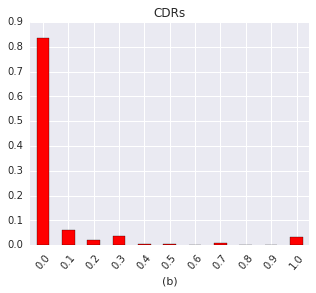

In [715]:

import matplotlib.pyplot as plt
import matplotlib
from pylab import mpl
myfont = matplotlib.font_manager.FontProperties(fname='chapter1data/simhei.ttf')  
mpl.rcParams['axes.unicode_minus'] = False 

def GetPlotClust(df):
    df_cut=pd.cut(df.ClustCf,bins=11,labels=np.arange(0,1.1,0.1))
    df_cut_cnt=df_cut.value_counts()
    df_stats=(df_cut_cnt/df_cut_cnt.sum()).sort_index()
    return df_stats
ax=GetPlotClust(CDR).plot.bar(color='red',rot=50,title='CDRs',figsize=(5,4))
ax.set_xlabel('(b)')

In [14]:
MPCs=LoadPajek_PUNGraph('chapter1data/app_conatcts_MxWcc.out')

In [16]:
MPCs.GetNodes()

5260679

In [25]:
import snap

Graph = snap.GenRndGnm(snap.PNGraph, 100, 1000)
K = 5
KCore = snap.GetKCore(Graph, K)
if KCore.Empty():
    print 'No Core exists for K=%d' % K
else:
    print 'Core exists for K=%d' % K

Core exists for K=5


In [33]:
import snap

Graph = snap.GenRndGnm(snap.PNGraph, 30, 300)
CoreIDSzV = snap.TIntPrV()
kValue = snap.GetKCoreNodes(Graph, CoreIDSzV)
for item in CoreIDSzV:
    print "order: %d nodes: %d" % (item.GetVal1(), item.GetVal2())


order: 0 nodes: 30
order: 1 nodes: 30
order: 2 nodes: 30
order: 3 nodes: 30
order: 4 nodes: 30
order: 5 nodes: 30
order: 6 nodes: 30
order: 7 nodes: 30
order: 8 nodes: 30
order: 9 nodes: 30
order: 10 nodes: 30
order: 11 nodes: 30
order: 12 nodes: 30
order: 13 nodes: 30
order: 14 nodes: 30
order: 15 nodes: 30
order: 16 nodes: 27
